In [ ]:
### training a singlet classifier on DNA barcoded "ground truth" singlets for Zhang Melzer et al. 2023
### Created by Madeline E Melzer on 20231110
### Last edited by Madeline E Melzer on 20231215

In [17]:
import os
import xgboost
import sklearn
import shutil
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.io import mmread
import anndata
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from joblib import dump, load
print(xgboost.__version__)

np.random.seed(23)

2.0.2


In [2]:
main("FM01")

In [ ]:
def main(dataset):
    counts_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier", dataset, "10X_doublets/")
    labels_dir = os.path.join("/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier", dataset)
    results_dir = "/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/results/"
    #classifiers_dir = "/Users/mem3579/Library/CloudStorage/OneDrive-NorthwesternUniversity/Arispe and Goyal Labs/ZhangMelzerEtAl/data/classifier/classifiers/"

    features, labels_encoded, barcodes_1, matrix_array, genes = load_and_preprocess_data(counts_dir, labels_dir)
    #use_FM01_classifier(features, labels_encoded, barcodes_1, results_dir, classifiers_dir)
    train_classifier(features, labels_encoded, barcodes_1, dataset)
    negative_controls(features, barcodes_1, dataset, matrix_array, genes)
    

In [28]:
def load_and_preprocess_data(counts_dir, labels_dir):
    os.chdir(counts_dir)

    # Read the .mtx file
    matrix = scipy.io.mmread("matrix.mtx")
    matrix = matrix.transpose()
    matrix_array = matrix.toarray()

    # Read the features and barcodes files
    genes = pd.read_csv("features.tsv.gz", header=None, sep="\t")
    first_column = genes.columns[0]
    genes = genes.set_index(first_column) #this is to ensure the anndata object is created correctly and that there are no extra columns in the features or barcodes dfs
    barcodes = pd.read_csv("barcodes.tsv.gz", header=None, sep="\t")
    first_column = barcodes.columns[0]
    barcodes = barcodes.set_index(first_column)

    # Create the AnnData object
    data = anndata.AnnData(X=matrix_array, var=genes, obs=barcodes)

    # getting singlet and multiplet labels
    os.chdir(labels_dir)
    labels_df = pd.read_csv('labels.csv')

    ############## Preprocessing data

    # combining features matrix and labels
    data.obs.index = data.obs.index.rename('barcode')
    merged = data.obs.merge(labels_df, on='barcode', how='inner')
    print(merged.head()) #checking what the merged looks like

    # Extract the features matrix and labels
    features = data.X
    labels = merged['label'].values
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(dict(zip(unique_labels, counts))) #checking the number of singlets and multiplets

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = 1 - labels_encoded #switching the labels so that 1s are multiplets and 0s are singlets, so correclty identified 1s are considered true positives
    counts = np.bincount(labels_encoded)
    print(counts) #checking that the number of singlets and multiplets is the same as above

    barcodes_1 = data.obs.index.to_numpy() #getting the barcodes for the features matrix to identify the cells that are being classified

    return features, labels_encoded, barcodes_1, matrix_array, genes

In [29]:
def use_FM01_classifier(features, labels_encoded, barcodes_1, results_dir, classifiers_dir):
    os.chdir(classifiers_dir)
    unfit = load(classifiers_dir + 'FM01_1_tree_stratified_unfit.joblib')
    X_train, X_test, y_train, y_test, barcodes_train, barcodes_test = train_test_split(features, labels_encoded, barcodes_1, test_size=0.2, random_state=23, shuffle=True, stratify=labels_encoded) # 20% test set, 80% training set
    classifier = unfit.fit(X_train, y_train)

    preds_proba = classifier.predict_proba(X_test)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(y_test, preds_proba) # Calculate AUROC
    print(f"{dataset} trained on FM01 AUROC: {auroc}")
    auprc = average_precision_score(y_test, preds_proba) # Calculate AUPRC
    print(f"{dataset} trained on FM01 AUPRC: {auprc}")
    y_preds = classifier.predict(X_test) # Predict labels on the test set
    accuracy = accuracy_score(y_test, y_preds) # Calculate accuracy
    print(f"{dataset} trained on FM01 Accuracy: {accuracy}")

    results_fm01 = pd.DataFrame({
        'barcode': barcodes_test,
        'prediction probability': preds_proba,
        'predicted': y_preds,
        'actual': y_test
    })
    results_fm01.to_csv(os.path.join(results_dir, f"{dataset}_predicted_actual_FM01params.csv"))

    return results_fm01

In [30]:
def train_classifier(features, labels_encoded, barcodes_1, condition):

    X_train, X_test, y_train, y_test, barcodes_train, barcodes_test = train_test_split(features, labels_encoded, barcodes_1, test_size=0.2, random_state=23, shuffle=True, stratify=labels_encoded) # 20% test set, 80% training set
    # Define the hyperparameter space
    space_tree = {
        'n_estimators': hp.choice('n_estimators', range(1, 100)),
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 1),
        'objective': 'binary:logistic',
        'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
        'gamma': hp.uniform('gamma', 0.1, 1.0),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 1.0, 3.0),
        'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 100),
        'booster': 'gbtree'
    }

    # Define objective function
    def objective(params):
        bst = XGBClassifier(**params, random_state=23)
        bst.fit(X_train, y_train)
        preds = bst.predict(X_test)
        preds_proba = bst.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, preds)
        auroc = roc_auc_score(y_test, preds_proba)  # Calculate AUROC
        auprc = average_precision_score(y_test, preds_proba)  # Calculate AUPRC
        return {'loss': -auprc, 'accuracy': accuracy, 'status': STATUS_OK, 'auroc': auroc, 'auprc': auprc}

    # Run the hyperparameter optimization
    trials_tree = Trials()
    best_tree = fmin(fn=objective, space=space_tree, algo=tpe.suggest, max_evals=10, trials=trials_tree)
    print(f"{condition} Best parameters for tree: {best_tree}")

    # Summary of the success of the hyperparameter optimization
    best_tree_score = min(trials_tree.results, key=lambda x: x['loss'])
    print(f"{condition} Best tree score: {best_tree_score}")

    # Adjusting the hyperparameters
    best_params_tree = {
        'n_estimators': best_tree['n_estimators'] + 1,  # +1 because hp.choice returns an index
        'max_depth': best_tree['max_depth'] + 1,        # +1 for the same reason
        'learning_rate': best_tree['learning_rate'],
        'objective': 'binary:logistic',
        'min_child_weight': best_tree['min_child_weight'] + 1,  # Adjust if needed
        'gamma': best_tree['gamma'],
        'subsample': best_tree['subsample'],
        'reg_alpha': best_tree['reg_alpha'],
        'reg_lambda': best_tree['reg_lambda'],
        'scale_pos_weight': best_tree['scale_pos_weight'],
        'booster': 'gbtree'
    }

    # Retrain the classifier with the best hyperparameters
    bst_best = XGBClassifier(**best_params_tree, random_state=23)
    dump(bst_best, classifiers_dir + f'{dataset}.joblib') #saving unfit classifier
    bst_best.fit(X_train, y_train)

    preds_proba = bst_best.predict_proba(X_test)[:,1]  # Get probabilities of the positive class (multiplets- 1)
    auroc = roc_auc_score(y_test, preds_proba) # Calculate AUROC
    print(f"{condition} AUROC: {auroc}")
    auprc = average_precision_score(y_test, preds_proba) # Calculate AUPRC
    print(f"{condition} AUPRC: {auprc}")
    y_preds = bst_best.predict(X_test) # Predict labels on the test set
    accuracy = accuracy_score(y_test, y_preds) # Calculate accuracy
    print(f"{condition} Accuracy: {accuracy}")

    results = pd.DataFrame({
        'barcode': barcodes_test,
        'prediction probability': preds_proba,
        'predicted': y_preds,
        'actual': y_test
    })
    results.to_csv(os.path.join(results_dir, f"{condition}_predicted_actual.csv"))

In [58]:
def negative_controls(features, barcodes_1, dataset, matrix_array, genes):
    total_cells = len(features)
    num_doublets = int((len(features)*0.1)/0.9)
    num_singlets = int(total_cells - num_doublets)

    ############### singlets only

    # selecting only singlets as a control
    features_singlets = features[:(num_singlets), :] #singlets always first in the features matrix
    # creating fake doublets from those singlets
    labels_singlets = np.zeros(num_singlets)
    fakedoubletsforsinglets = int((len(features_singlets)*0.1)/0.9)
    # making 10% of the singlets into fake doublets
    labels_singlets[0:fakedoubletsforsinglets] = 1 

    barcodes_singlets = barcodes_1[:num_singlets]

    train_classifier(features_singlets, labels_singlets, barcodes_singlets, f"{dataset}_neg_control_singlets")
    
    ############### doublets only
    
    # selecting only doublets as a control
    features_doublets = features[-num_doublets:, :] #doublets always last in the features matrix
    # creating fake singlets from those doublets
    labels_doublets = np.ones(num_doublets)
    fakesingletsfordoublets = int(num_doublets - ((len(features_doublets)*0.1)/0.9))
    # making 90% of the doublets into fake singlets
    labels_doublets[0:fakesingletsfordoublets] = 0

    barcodes_doublets = barcodes_1[-num_doublets:]
    
    train_classifier(features_doublets, labels_doublets, barcodes_doublets, f"{dataset}_neg_control_doublets")

    ############### shuffling features

    shuffled_indices = np.random.permutation(matrix_array.shape[1]) # Generate a shuffled index
    matrix_array_shuffled = matrix_array[:, shuffled_indices] # Shuffle the columns of the matrix
    genes_shuffled = genes.iloc[shuffled_indices] # Reorder the features DataFrame to match the new column order (NOTE: this doesnt get used here)

    shuffled_data = anndata.AnnData(X=matrix_array_shuffled, var=genes_shuffled, obs=barcodes_1) #(NOTE: this doesnt get used here-- should i use it? probably unnecessary to specify gene names)

    features_shuffled = shuffled_data.X

    train_classifier(features_shuffled, labels_encoded, barcodes_1, f"{dataset}_neg_control_shuffled")

    ############### scrambling features

    flattened_matrix = matrix_array.flatten()
    np.random.shuffle(flattened_matrix)
    scrambled_matrix_array = flattened_matrix.reshape(matrix_array.shape)

    features_scrambled = scrambled_matrix_array

    train_classifier(features_scrambled, labels_encoded, barcodes_1, f"{dataset}_neg_control_scrambled")

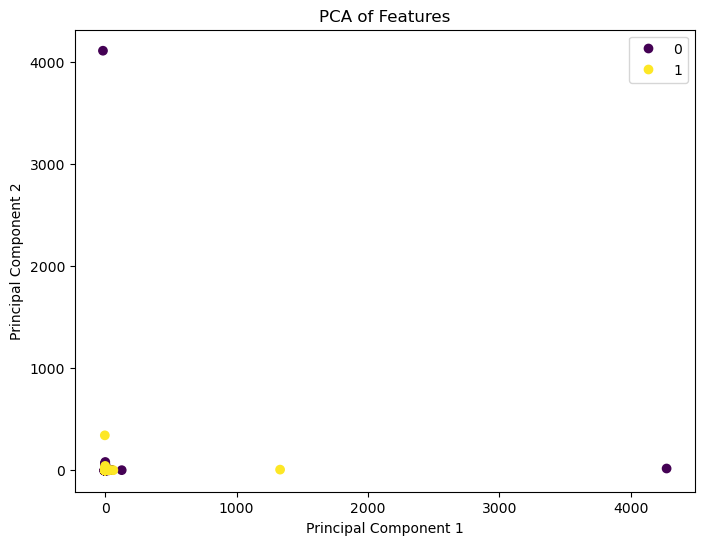

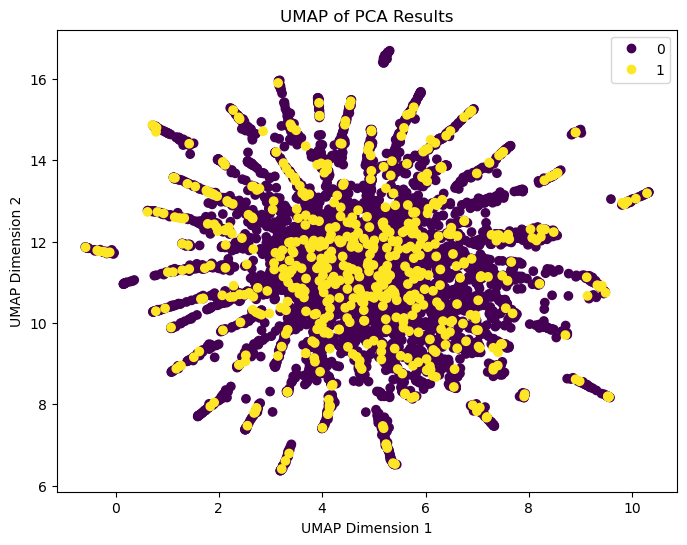

In [22]:
# Dimensionality reduction and data visualization

from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

# Perform PCA on your features
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data = pca_result, columns = ['PC' + str(i) for i in range(1, 51)])

# Add the labels to the DataFrame
pca_df['Label'] = labels_encoded

# Plot the PCA results colored by label
plt.figure(figsize=(8,6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Label'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Features')
plt.legend(handles=scatter.legend_elements()[0], labels=set(pca_df['Label']))
plt.show()

# Perform UMAP on the PCA results
umap = UMAP()
umap_result = umap.fit_transform(pca_result)

# Create a DataFrame for the UMAP results
umap_df = pd.DataFrame(data = umap_result, columns = ['UMAP1', 'UMAP2'])

# Add the labels to the DataFrame
umap_df['Label'] = labels_encoded

# Plot the UMAP results colored by label
plt.figure(figsize=(8,6))
scatter = plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c=umap_df['Label'])
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP of PCA Results')
plt.legend(handles=scatter.legend_elements()[0], labels=set(umap_df['Label']))
plt.show()